In [1]:
import os
from decimal import Decimal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'figure.titlesize': 18,
    'axes.axisbelow': True
})


FIGURE_SIZE = (10, 4.125)

LINE_STYLE = {
    "linewidth": 1.5,
    "linestyle": "-"  # solid lines
}

GRID_STYLE = {
    "visible": True,
    "linestyle": "--",
    "alpha": 0.6
}

dark_blue = "#003366"
wine_red = "#800000"
dark_green = "#006400"
bright_blue = "#4C72B0"
bright_green = "#55A868"
bright_red = "#96595b"
color_list = [bright_red, bright_green, bright_blue]

In [3]:
STAGE_NAME = {
    0: "Bootstrapping and Exit",
    1: "Training",
    2: "Evaluation",
    3: "Broadcasting, Forwarding & Collection",
    4: "Evaluation"
}

metrics_path = '../metrics/'
figure_path = '3_figures/'

nr_nodes = [2, 4, 6, 8, 10]
nr_hops = [1, 2, 3, 4]
outbox_size = [10 + (i) * 30 for i in range(6)]


In [4]:
def load_file(path):
    df = pd.read_csv(path, comment='#')
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')
        bad = ts.isna()
        if bad.any():
            ts.loc[bad] = pd.to_datetime(df.loc[bad, 'timestamp'].str.replace('Z', '+00:00'), utc=True, errors='coerce')
        df = df.assign(timestamp=ts).dropna(subset=['timestamp'])
    else:
        df['timestamp'] = pd.Timestamp.utcnow()
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    return df

In [5]:
def reduce_to_stage_timestamp_node(df, stage_field='stage'):
    dff = df[df['field'] == stage_field].copy()
    dff = dff[['timestamp', 'node', 'value']].rename(columns={'value': 'stage'})
    dff['stage'] = pd.to_numeric(dff['stage'], errors='coerce').replace({4: 2}).astype('Int64')
    dff = dff.dropna(subset=['stage'])
    dff = dff.sort_values(['node', 'timestamp']).drop_duplicates(['node', 'timestamp'], keep='last')
    return dff


In [6]:
def collapse_stage_runs(stages_df):
    stages_df = stages_df.sort_values(['node', 'timestamp']).copy()
    stages_df['stage_change'] = stages_df.groupby('node', group_keys=False)['stage'].apply(lambda s: s.ne(s.shift()).astype('Int64'))
    stages_df['run_id'] = stages_df.groupby('node')['stage_change'].cumsum().astype('Int64')
    agg = (
        stages_df
        .groupby(['node', 'stage', 'run_id'], as_index=False)
        .agg(start_timestamp=('timestamp', 'first'),
             end_timestamp=('timestamp', 'last'),
             samples=('timestamp', 'size'))
    )
    agg['duration_seconds'] = (agg['end_timestamp'] - agg['start_timestamp']).dt.total_seconds().fillna(0)
    agg = agg.sort_values(['node', 'start_timestamp']).reset_index(drop=True)
    agg = agg[['node', 'stage', 'start_timestamp', 'end_timestamp', 'duration_seconds', 'samples']]
    return agg


In [7]:
def extract_cpu(df, cpu_field='cpu_total_ns'):
    cpu = df[df['field'] == cpu_field].copy()
    cpu = cpu[['timestamp', 'node', 'value']].rename(columns={'value': 'cpu_total_ns'})
    cpu['cpu_total_ns'] = pd.to_numeric(cpu['cpu_total_ns'], errors='coerce')
    cpu = cpu.sort_values(['node', 'timestamp'])
    cpu['cpu_total_ns'] = cpu.groupby('node')['cpu_total_ns'].ffill()
    return cpu


In [8]:
def attach_cpu_to_runs(collapsed_runs, cpu_df):
    runs = collapsed_runs.copy()
    cpu = cpu_df.copy()
    cpu = cpu.sort_values(['node', 'timestamp'])

    runs = runs.sort_values(['node', 'start_timestamp', 'end_timestamp'])

    start_cpu = pd.merge_asof(
        runs.sort_values('start_timestamp'),
        cpu[cpu['cpu_total_ns'].notna()].sort_values('timestamp'),
        left_on='start_timestamp',
        right_on='timestamp',
        by='node',
        direction='backward'
    ).rename(columns={'cpu_total_ns': 'cpu_start_ns'}).drop(columns=['timestamp'])

    end_cpu = pd.merge_asof(
        start_cpu.sort_values('end_timestamp'),
        cpu[cpu['cpu_total_ns'].notna()].sort_values('timestamp'),
        left_on='end_timestamp',
        right_on='timestamp',
        by='node',
        direction='backward'
    ).rename(columns={'cpu_total_ns': 'cpu_end_ns'}).drop(columns=['timestamp'])

    out = end_cpu

    out['cpu_start_ns'] = pd.to_numeric(out['cpu_start_ns'], errors='coerce')
    out['cpu_end_ns'] = pd.to_numeric(out['cpu_end_ns'], errors='coerce')

    out['cpu_ns_used'] = out.apply(
        lambda row: Decimal(row['cpu_end_ns']) - Decimal(row['cpu_start_ns']), axis=1
    )
    out['cpu_seconds_used'] = out['cpu_ns_used'].apply(lambda x: x / Decimal(1e9))

    return out


In [9]:
def load_and_aggregate_cpu_per_stage(file_paths, x_values, x_label_name, stage_labels=None):
    records = []
    for fpath, xval in zip(file_paths, x_values):
        df = load_file(fpath)
        stages_only = reduce_to_stage_timestamp_node(df, stage_field='stage')
        collapsed = collapse_stage_runs(stages_only)
        cpu_df = extract_cpu(df, cpu_field='cpu_total_ns')
        runs_with_cpu = attach_cpu_to_runs(collapsed, cpu_df)
        grp = runs_with_cpu.groupby('stage', as_index=False)['cpu_seconds_used'].sum()
        for _, row in grp.iterrows():
            records.append({'x': xval, 'stage': int(row['stage']), 'cpu_seconds': float(row['cpu_seconds_used'])})
    out = pd.DataFrame.from_records(records)
    if out.empty:
        return out, []
    if stage_labels is None:
        stage_labels = [s for s in [1, 2, 3] if s in out['stage'].unique()]
    pivot = out.pivot_table(index='x', columns='stage', values='cpu_seconds', aggfunc='sum', fill_value=0.0)
    pivot = pivot.reindex(columns=stage_labels, fill_value=0.0)
    pivot = pivot.reindex(index=x_values[:len(pivot.index)], fill_value=0.0)
    pivot.index.name = x_label_name
    return pivot, stage_labels

In [10]:
def normalize_to_percentage(pivot):
    row_sums = pivot.sum(axis=1)
    normalized = pivot.div(row_sums, axis=0) * 100
    return normalized


In [11]:
def plot_bar_chart(axis, data, stage_labels, x_labels, x_label_name, y_label, title=None, factor=1):
    x = np.arange(len(data.index))
    width = 0.7
    bottoms = np.zeros(len(x))

    for i, stage in enumerate(stage_labels):
        vals = data[stage].values if stage in data.columns else np.zeros(len(x))
        bars = axis.bar(x, vals, width=width, bottom=bottoms, label=STAGE_NAME.get(stage, f"stage {stage}"), color=color_list[i])

        for bar, val, bottom in zip(bars, vals, bottoms):
            if val > 0:
                axis.text(
                    bar.get_x() + bar.get_width() / 2,
                    bottom + val / 2,
                    f'{val * factor:.2f}' if val * factor >= 0.1 else f'',
                    ha='center',
                    va='center',
                    fontsize=10,
                    color='white'5
                )

        bottoms += vals

    axis.set_xticks(x)
    axis.set_xticklabels([str(ix) for ix in x_labels])
    axis.set_xlabel(x_label_name)
    axis.set_ylabel(y_label)

    if title:
        axis.set_title(title)


In [12]:
def plot_side_by_side(pivot1, pivot2, stage_labels, x_label_name1, x_label_name2, y_label, title1=None, title2=None, normalize=False, factor=1, overall_title=None):
    if normalize:
        pivot1 = normalize_to_percentage(pivot1)
        pivot2 = normalize_to_percentage(pivot2)

    fig, axes = plt.subplots(1, 2, figsize=FIGURE_SIZE, sharey=True)

    if overall_title:
        fig.suptitle(overall_title, fontsize=18)

    plot_bar_chart(axes[0], pivot1, stage_labels, pivot1.index, x_label_name1, y_label, title1, factor=factor)
    plot_bar_chart(axes[1], pivot2, stage_labels, pivot2.index, x_label_name2, y_label, title2, factor=factor)

    axes[1].set_ylabel('')

    handles, labels = axes[0].get_legend_handles_labels()

    fig.legend(handles, labels, loc='lower center', ncol=len(stage_labels), bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(bottom=0.2)
    plt.savefig(os.path.join(figure_path, f"{overall_title}.pdf".lower().replace(' ', '_').replace('/', '-')), dpi=600, bbox_inches='tight')
    plt.show()


In [13]:
files_nodes = [os.path.join(metrics_path, "nr_nodes", f) for f in sorted(os.listdir(os.path.join(metrics_path, "nr_nodes")))]
pivot_nodes, stages = load_and_aggregate_cpu_per_stage(files_nodes, nr_nodes[:len(files_nodes)], "Number of Nodes")

files_hops = [os.path.join(metrics_path, "max_hops", f) for f in sorted(os.listdir(os.path.join(metrics_path, "max_hops")))]
pivot_hops, _ = load_and_aggregate_cpu_per_stage(files_hops, nr_hops[:len(files_hops)], "Maximum Hops")

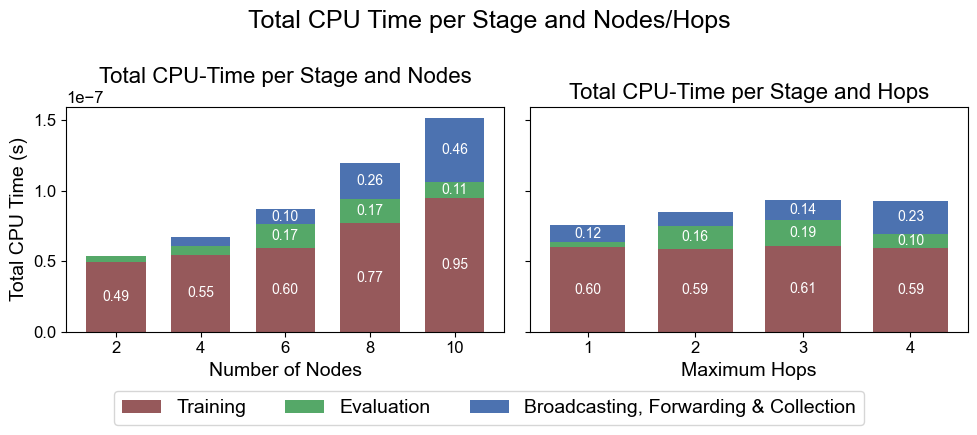

In [14]:
plot_side_by_side(
    pivot_nodes, pivot_hops, stages,
    "Number of Nodes", "Maximum Hops", "Total CPU Time (s)",
    title1="Total CPU-Time per Stage and Nodes",
    title2="Total CPU-Time per Stage and Hops",
    factor=1e7,
    overall_title="Total CPU Time per Stage and Nodes/Hops"
)


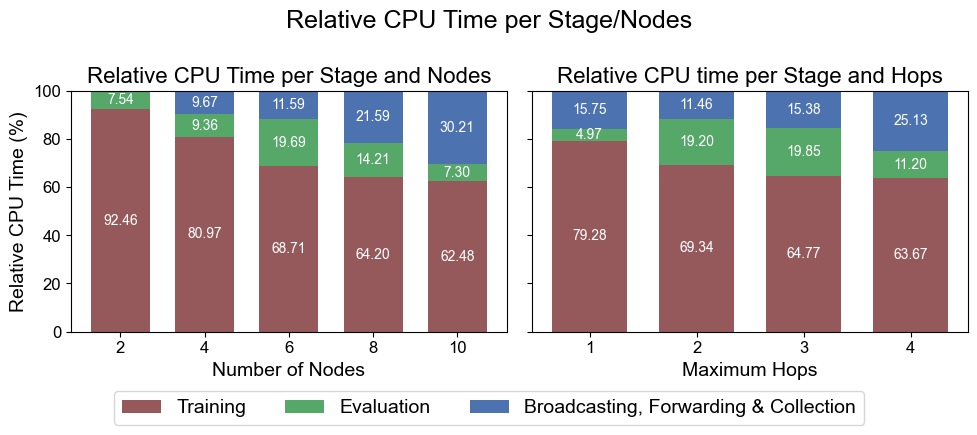

In [15]:
plot_side_by_side(
    pivot_nodes, pivot_hops, stages,
    "Number of Nodes", "Maximum Hops", "Relative CPU Time (%)",
    title1="Relative CPU Time per Stage and Nodes",
    title2="Relative CPU time per Stage and Hops",
    normalize=True,
    overall_title="Relative CPU Time per Stage/Nodes"
)


In [16]:
def extract_memory(df, mem_field='memory_mb'):
    mem = df[df['field'] == mem_field].copy()
    mem = mem[['timestamp', 'node', 'value']].rename(columns={'value': 'memory_mb'})
    mem['memory_mb'] = pd.to_numeric(mem['memory_mb'], errors='coerce')
    mem = mem.sort_values(['node', 'timestamp'])
    mem['memory_mb'] = mem.groupby('node')['memory_mb'].ffill()
    return mem

def attach_memory_to_runs_average(collapsed_runs, mem_df):
    runs = collapsed_runs.copy()
    mem = mem_df.copy().sort_values(['node', 'timestamp'])
    out_rows = []
    for node, g in runs.groupby('node'):
        gmem = mem[mem['node'] == node]
        for _, r in g.iterrows():
            mask = (gmem['timestamp'] >= r['start_timestamp']) & (gmem['timestamp'] <= r['end_timestamp'])
            vals = gmem.loc[mask, 'memory_mb']
            avg_mem = float(vals.mean()) if not vals.empty else np.nan
            out_rows.append({
                'node': node,
                'stage': int(r['stage']),
                'start_timestamp': r['start_timestamp'],
                'end_timestamp': r['end_timestamp'],
                'samples': r['samples'],
                'avg_memory_mb': avg_mem
            })
    return pd.DataFrame(out_rows)

def load_and_aggregate_memory_per_stage(file_paths, x_values, x_label_name, stage_labels=None):
    records = []
    for fpath, xval in zip(file_paths, x_values):
        df = load_file(fpath)
        stages_only = reduce_to_stage_timestamp_node(df, stage_field='stage')
        collapsed = collapse_stage_runs(stages_only)
        mem_df = extract_memory(df, mem_field='memory_mb')
        runs_with_mem = attach_memory_to_runs_average(collapsed, mem_df).dropna(subset=['avg_memory_mb'])
        grp = runs_with_mem.groupby('stage', as_index=False)['avg_memory_mb'].mean()
        for _, row in grp.iterrows():
            records.append({'x': xval, 'stage': int(row['stage']), 'avg_memory_mb': float(row['avg_memory_mb'])})
    out = pd.DataFrame.from_records(records)
    if out.empty:
        return out, []
    if stage_labels is None:
        stage_labels = [s for s in [1, 2, 3] if s in out['stage'].unique()]
    pivot = out.pivot_table(index='x', columns='stage', values='avg_memory_mb', aggfunc='mean', fill_value=0.0)
    pivot = pivot.reindex(columns=stage_labels, fill_value=0.0)
    pivot = pivot.reindex(index=x_values[:len(pivot.index)], fill_value=0.0)
    pivot.index.name = x_label_name
    return pivot, stage_labels

files_nodes_mem = [os.path.join(metrics_path, "nr_nodes", f) for f in sorted(os.listdir(os.path.join(metrics_path, "nr_nodes")))]
pivot_nodes_mem, stages_mem = load_and_aggregate_memory_per_stage(files_nodes_mem, nr_nodes[:len(files_nodes_mem)], "Number of Nodes")

files_hops_mem = [os.path.join(metrics_path, "max_hops", f) for f in sorted(os.listdir(os.path.join(metrics_path, "max_hops")))]
pivot_hops_mem, _ = load_and_aggregate_memory_per_stage(files_hops_mem, nr_hops[:len(files_hops_mem)], "Maximum Hops")


In [17]:
def plot_grouped_bars(axis, data, stage_labels, x_labels, x_label_name, y_label, title=None):
    x = np.arange(len(data.index))
    n_stages = len(stage_labels)
    width = 0.8 / max(1, n_stages)
    for i, stage in enumerate(stage_labels):
        vals = data[stage].values if stage in data.columns else np.zeros(len(x))
        offsets = x - 0.4 + i * width + width / 2.0
        axis.bar(offsets, vals, width=width, label=STAGE_NAME.get(stage, f"stage {stage}"), color=color_list[i])
    axis.set_xticks(x)
    axis.set_xticklabels([str(ix) for ix in x_labels])
    axis.set_xlabel(x_label_name)
    axis.set_ylabel(y_label)
    if title:
        axis.set_title(title)

def plot_side_by_side_grouped(pivot1, pivot2, stage_labels, x_label_name1, x_label_name2, y_label, title1=None, title2=None, normalize=False, overall_title=None):
    if normalize:
        pivot1 = normalize_to_percentage(pivot1)
        pivot2 = normalize_to_percentage(pivot2)

    fig, axes = plt.subplots(1, 2, figsize=FIGURE_SIZE, sharey=True)

    if overall_title:
        fig.suptitle(overall_title, fontsize=18)

    plot_grouped_bars(axes[0], pivot1, stage_labels, pivot1.index, x_label_name1, y_label, title1)
    plot_grouped_bars(axes[1], pivot2, stage_labels, pivot2.index, x_label_name2, '', title2)

    axes[1].set_ylabel('')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(stage_labels), bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(bottom=0.2)
    plt.savefig(os.path.join(figure_path, f"{overall_title}.pdf".lower().replace(' ', '_').replace('/', '-')), dpi=600, bbox_inches='tight')
    plt.show()


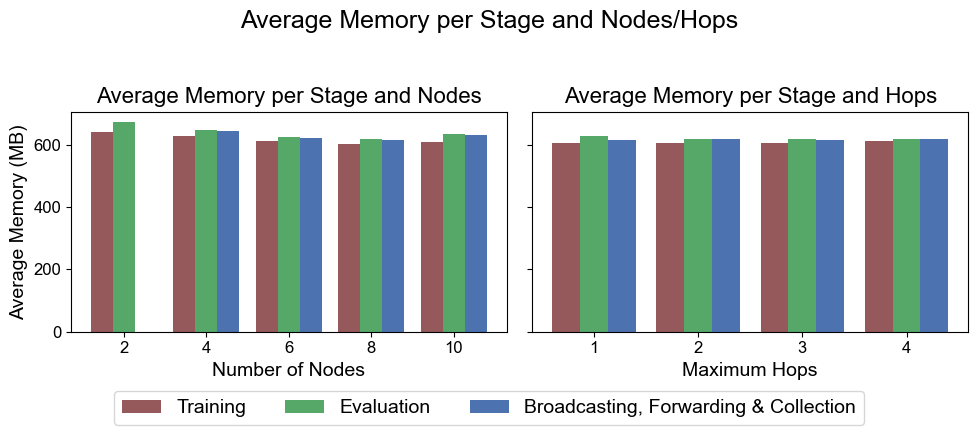

In [18]:
plot_side_by_side_grouped(
    pivot_nodes_mem, pivot_hops_mem, stages_mem,
    "Number of Nodes", "Maximum Hops", "Average Memory (MB)",
    title1="Average Memory per Stage and Nodes",
    title2="Average Memory per Stage and Hops",
    normalize=False,
    overall_title="Average Memory per Stage and Nodes/Hops"
)
